1. 首先处理数据
2. 数据可视化
2.1. 首先选几个切片，去画地图，1900, 1950, 2000
2.2. 选三个城市做arima相关的eda【赤道，北半球，南半球】
2.3. 通过这个eda，我们来确定大致的arima的参数范围
3. 通过grid search，来选择每个arima模型最合适的参数
4. apply grid search的结果，有100（city 数量）arima model
5. 可以去画最终的结果，还有地图


In [47]:
import warnings

import matplotlib.pyplot as plt
# Import libraries
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pandasql as ps

warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [2]:
df = pd.read_csv('./processed_data.csv')[['datetime', 'AverageTemperature', 'City', 'Latitude', 'Longitude']]
df.rename(
    columns={'AverageTemperature': 'average_temperature', 'City': 'city', 'datetime': 'dates', 'Latitude': 'latitude',
             'Longitude': 'longitude'}, inplace=True)
df['dates'] = pd.to_datetime(df['dates'])
df['dates'] = df['dates'] + pd.offsets.MonthEnd(0)
df['year'] = df.dates.dt.year
df

dates  average_temperature     city  latitude  longitude  year
0      1900-01-31               25.696  Abidjan      5.63      -3.23  1900
1      1900-02-28               27.816  Abidjan      5.63      -3.23  1900
2      1900-03-31               28.395  Abidjan      5.63      -3.23  1900
3      1900-04-30               27.706  Abidjan      5.63      -3.23  1900
4      1900-05-31               26.753  Abidjan      5.63      -3.23  1900
...           ...                  ...      ...       ...        ...   ...
135595 2012-08-31               23.885     Xian     34.56     108.97  2012
135596 2012-09-30               17.028     Xian     34.56     108.97  2012
135597 2012-10-31               12.399     Xian     34.56     108.97  2012
135598 2012-11-30                4.736     Xian     34.56     108.97  2012
135599 2012-12-31               -0.822     Xian     34.56     108.97  2012

[135600 rows x 6 columns]

In [3]:
df_yearly = df.groupby(['year', 'city']).mean().reset_index()
single_df_1900 = df_yearly[df_yearly.year == 1900]
fig = px.density_mapbox(single_df_1900
                        , lat='latitude'  #设置纬度
                        , lon='longitude'  #设置经度
                        , z='average_temperature'  #设置密度
                        , radius=60,
                        center=dict(lat=40, lon=118)  #设置地图的中心点
                        , zoom=2  #设置地图的缩放等级0-20
                        , mapbox_style="stamen-terrain"
                        , color_continuous_scale='inferno'
                        )  #设置地图的底图

fig.show()

In [4]:
single_df_1950 = df_yearly[df_yearly.year == 1950]
fig = px.density_mapbox(single_df_1950
                        , lat='latitude'  #设置纬度
                        , lon='longitude'  #设置经度
                        , z='average_temperature'  #设置密度
                        , radius=60,
                        center=dict(lat=40, lon=118)  #设置地图的中心点
                        , zoom=2  #设置地图的缩放等级0-20
                        , mapbox_style="stamen-terrain"
                        , color_continuous_scale='inferno'
                        )  #设置地图的底图

fig.show()

In [5]:
single_df_2000 = df_yearly[df_yearly.year == 2000]
fig = px.density_mapbox(single_df_2000
                        , lat='latitude'  #设置纬度
                        , lon='longitude'  #设置经度
                        , z='average_temperature'  #设置密度
                        , radius=60,
                        center=dict(lat=40, lon=118)  #设置地图的中心点
                        , zoom=2  #设置地图的缩放等级0-20
                        , mapbox_style="stamen-terrain"
                        , color_continuous_scale='inferno'
                        )  #设置地图的底图

fig.show()

<Axes: xlabel='gap', ylabel='Count'>

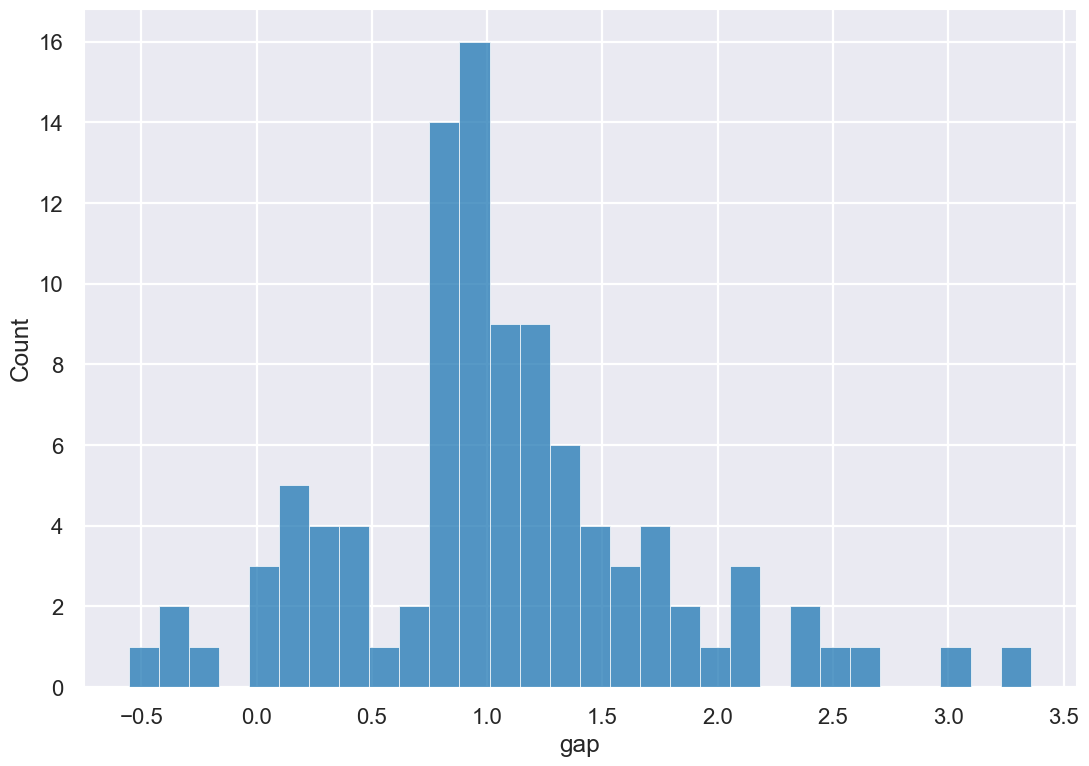

In [6]:
temperature_1900_2010 = df_yearly[df_yearly.year.isin([1900, 2010])].pivot(index='city', columns='year',
                                                                           values='average_temperature')
temperature_1900_2010['gap'] = temperature_1900_2010[2010] - temperature_1900_2010[1900]
temperature_1900_2010.sort_values(by=['gap'], inplace=True, ascending=False)
sns.histplot(data=temperature_1900_2010, x='gap', bins=30)

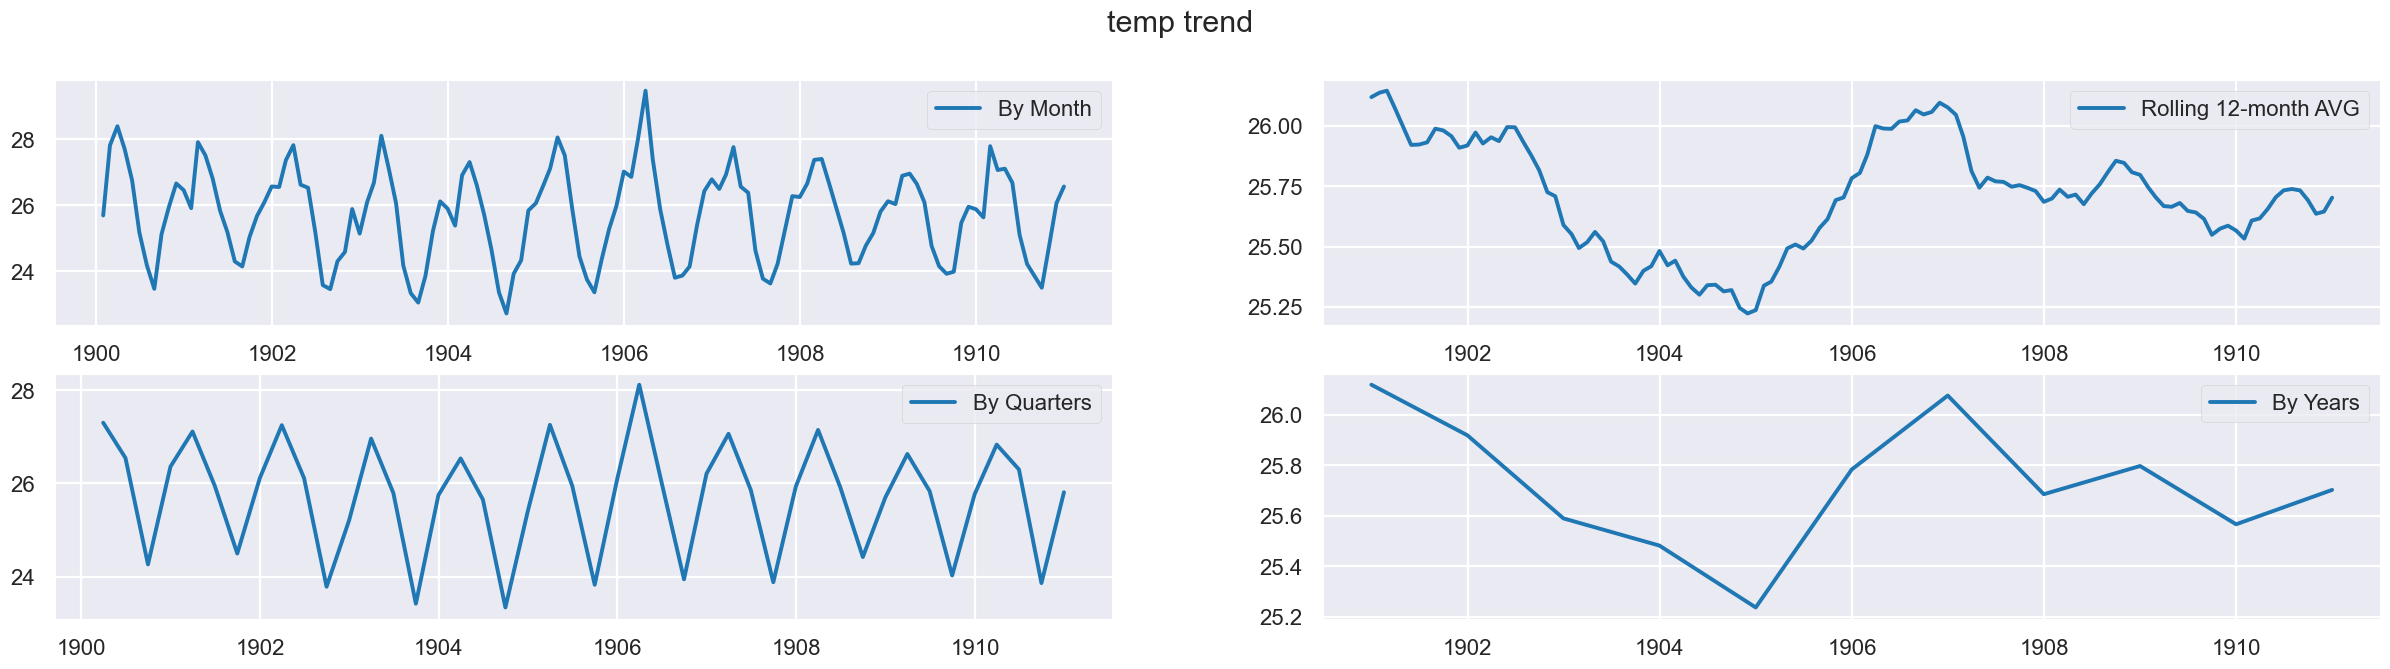

In [7]:
# Resampling to daily frequency
sample_df = df[(df.city == 'Abidjan') & (df.year >= 1900) & (df.year <= 1910)]
sample_df.index = sample_df.dates
sample_df = sample_df.resample('M').mean()

# roll 4 month avg
roll_4_month_sample_df = sample_df.rolling(12).mean()

# Resampling to annual frequency
df_year = sample_df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = sample_df.resample('Q-DEC').mean()

# PLOTS
fig = plt.figure(figsize=[30, 7])
plt.suptitle('temp trend', fontsize=22)

plt.subplot(221)
plt.plot(sample_df.average_temperature, '-', label='By Month')
plt.legend()

plt.subplot(222)
plt.plot(roll_4_month_sample_df.average_temperature, '-', label='Rolling 12-month AVG')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.average_temperature, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.average_temperature, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

adfuller test: p=0.173
The series are not stationary.


<Figure size 1500x700 with 0 Axes>

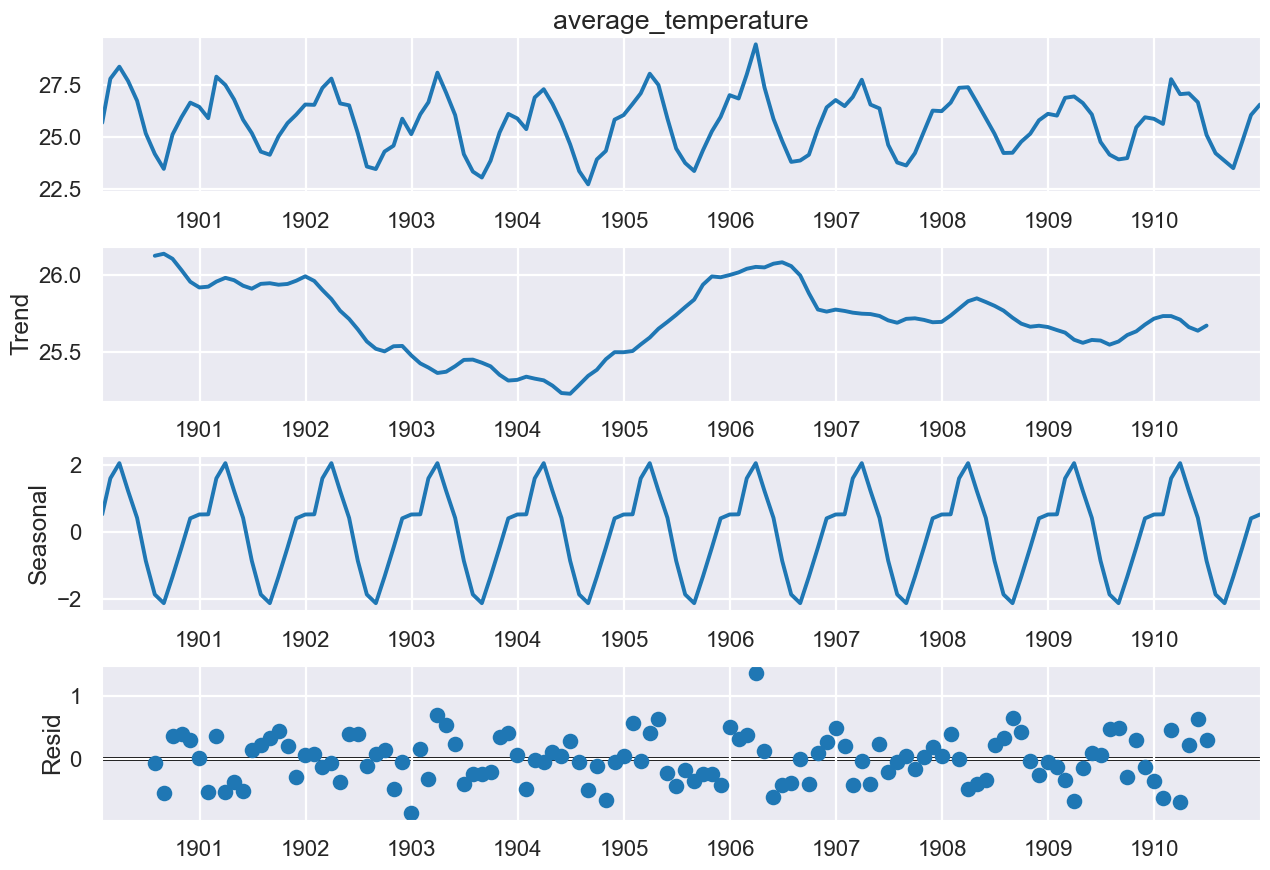

In [8]:
# Stationarity check and STL-decomposition of the series
plt.figure(figsize=[15, 7])
sm.tsa.seasonal_decompose(sample_df.average_temperature).plot()
p_value = sm.tsa.stattools.adfuller(sample_df.average_temperature)[1]
print(f"adfuller test: p={p_value:.3f}")
if p_value > 0.05:
    print("The series are not stationary.")
else:
    print('The series are stationary.')
plt.show()

In [9]:
# Seasonal differentiation
sample_df['average_temperature_diff'] = sample_df.average_temperature.diff(12)
p_value = sm.tsa.stattools.adfuller(sample_df.average_temperature_diff[12:])[1]
print(f"adfuller test: p={p_value:.3f}")
if p_value > 0.05:
    print("The series are not stationary.")
else:
    print('The series are stationary.')

adfuller test: p=0.090
The series are not stationary.


adfuller test: p=0.000
The series are stationary.


<Figure size 1500x700 with 0 Axes>

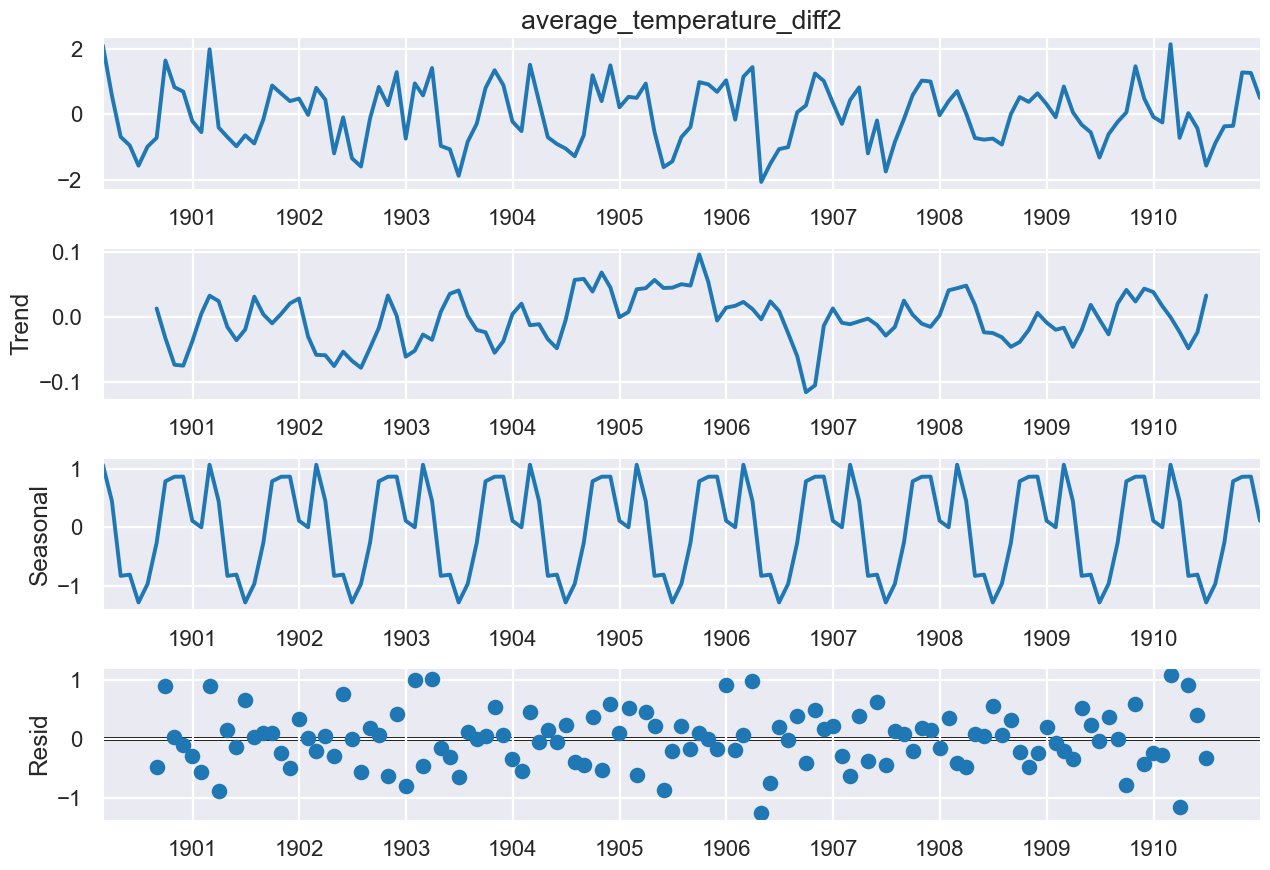

In [10]:
# Regular differentiation
sample_df['average_temperature_diff2'] = sample_df.average_temperature.diff(1)
plt.figure(figsize=(15, 7))

# STL-decomposition
sm.tsa.seasonal_decompose(sample_df['average_temperature_diff2'][1:]).plot()
p_value = sm.tsa.stattools.adfuller(sample_df['average_temperature_diff2'][1:])[1]
print(f"adfuller test: p={p_value:.3f}")
if p_value > 0.05:
    print("The series are not stationary.")
else:
    print('The series are stationary.')
plt.show()

arima 如何选择参数
1. 首先选D，d代表diff，选最小的d能是stationary的
2. 根据这个D选择pq
3. https://www.codercto.com/a/41483.html
4. https://blog.csdn.net/jaffe507/article/details/105834597

In [61]:
sample_df = df[df.city == 'Abidjan'][['dates', 'average_temperature']]
sample_df.set_index('dates', inplace=True)
train_data = sample_df.loc[sample_df.index < '1980-01-01']
train_data

average_temperature
dates                          
1900-01-31               25.696
1900-02-28               27.816
1900-03-31               28.395
1900-04-30               27.706
1900-05-31               26.753
...                         ...
1979-08-31               24.970
1979-09-30               25.437
1979-10-31               26.196
1979-11-30               26.906
1979-12-31               26.377

[960 rows x 1 columns]

adfuller test: p=0.002
The series are stationary.


<Figure size 1500x700 with 0 Axes>

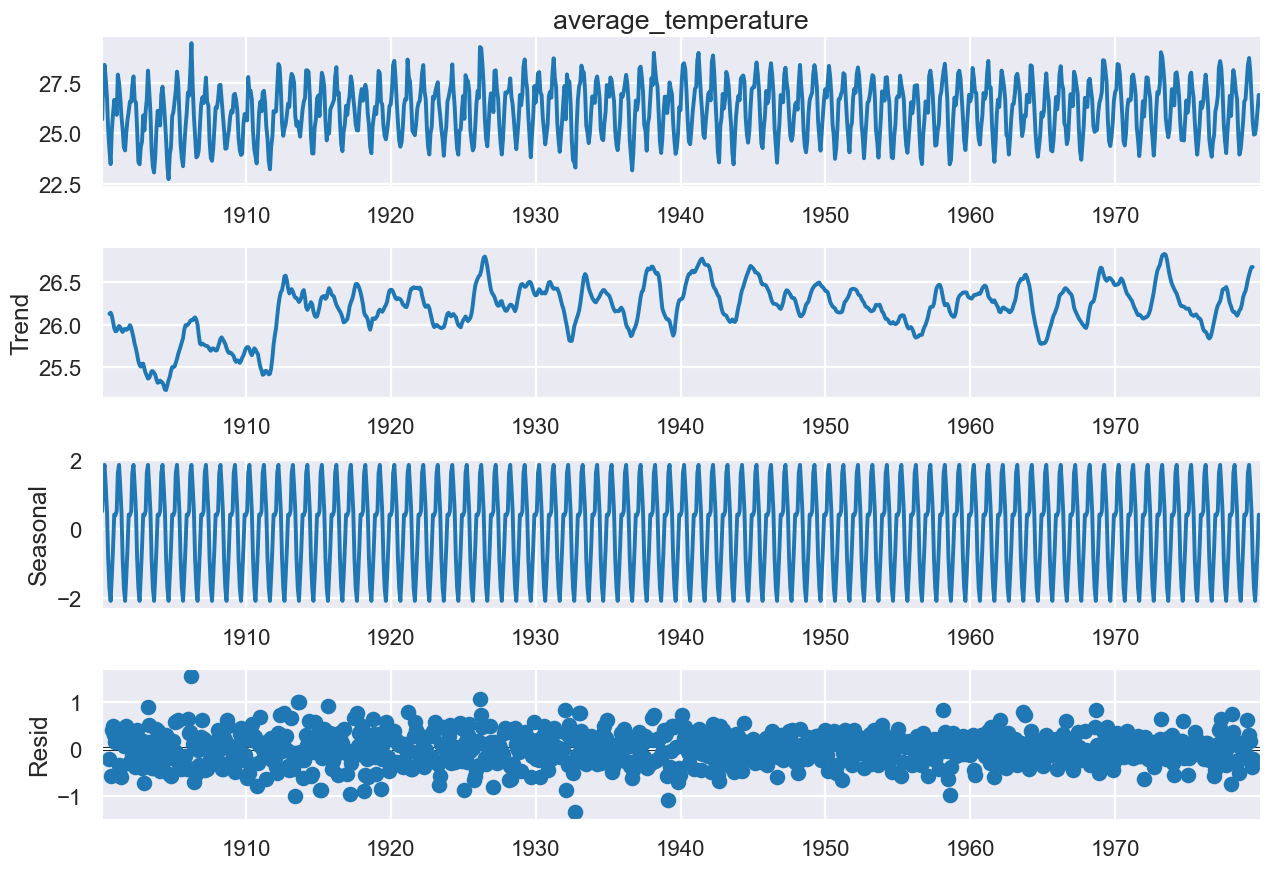

d is 0 or 1


In [46]:
# Regular differentiation
# train_data['average_temperature_diff2'] = train_data.average_temperature
plt.figure(figsize=(15, 7))

# STL-decomposition
sm.tsa.seasonal_decompose(train_data['average_temperature'][0:]).plot()
p_value = sm.tsa.stattools.adfuller(train_data['average_temperature'][0:])[1]
print(f"adfuller test: p={p_value:.3f}")
if p_value > 0.05:
    print("The series are not stationary.")
else:
    print('The series are stationary.')
plt.show()
print(f"d is 0 or 1")

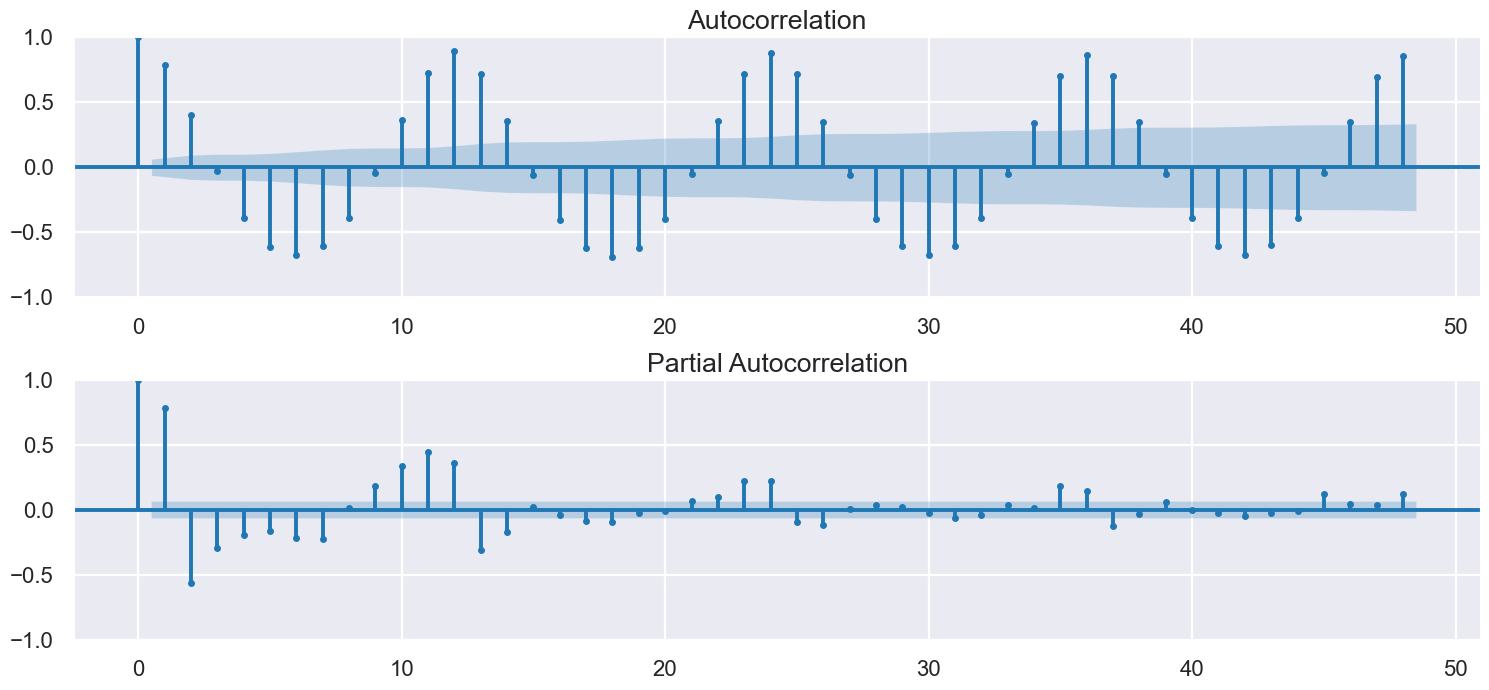

In [13]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_data['average_temperature'], lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_data['average_temperature'], lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [15]:
# acf 和pacf都是拖尾 考虑ARMA模型
# 我们使用包自动选择
hyper_options = sm.tsa.arma_order_select_ic(train_data['average_temperature'], ic=['aic', 'bic'], trend='n', max_ar=8, max_ma=8)
print(f"AIC", hyper_options.aic_min_order)
print(f"BIC", hyper_options.bic_min_order)

AIC (8, 8)
BIC (8, 8)


In [68]:
def get_metric(y_true, y_predict):
    RMSE = np.sqrt(mean_squared_error(y_true, y_predict))
    # MAE = mean_absolute_error(y_true, y_predict)
    # MAPE = mean_absolute_percentage_error(y_true, y_predict)
    return RMSE

In [72]:
from tqdm import tqdm
metrics = []
for i in tqdm(range(10)):
    train_begin = pd.to_datetime('1900-01-01') + pd.DateOffset(years=i) + pd.offsets.MonthEnd(0)
    train_end = train_begin + pd.DateOffset(years=80) + pd.offsets.MonthEnd(0)
    valid_begin = train_begin + pd.DateOffset(years=90) + pd.offsets.MonthEnd(0)
    valid_end = valid_begin + pd.DateOffset(years=1) + pd.offsets.MonthEnd(0)
    sql = f"""
    select dates, average_temperature from df
    where dates >= '{train_begin}'
    and dates < '{train_end}'
    and city = 'Abidjan'
    """
    train_data = ps.sqldf(sql)

    sql = f"""
    select dates, average_temperature from df
    where dates >= '{valid_begin}'
    and dates <= '{valid_end}'
    and city = 'Abidjan'
    """
    valid_data = ps.sqldf(sql)

    train_data.set_index('dates', inplace=True)
    valid_data.set_index('dates', inplace=True)
    model=ARIMA(train_data.average_temperature, order=(8, 0, 8)).fit()
    predict = pd.DataFrame(model.forecast(steps=132)[120:132]).rename(columns={'predicted_mean':'predict'})
    metric = get_metric(valid_data, predict)
    metrics.append([metric, train_begin, train_end, valid_begin, valid_end])
metrics = pd.DataFrame(metrics, columns=['RMSE', 'train_begin', 'train_end', 'valid_begin', 'valid_end'])
metrics

RMSE train_begin  train_end valid_begin  valid_end
0  0.486519  1900-01-31 1980-01-31  1990-01-31 1991-01-31
1  0.558955  1901-01-31 1981-01-31  1991-01-31 1992-01-31
2  0.428089  1902-01-31 1982-01-31  1992-01-31 1993-01-31
3  0.601913  1903-01-31 1983-01-31  1993-01-31 1994-01-31
4  0.465652  1904-01-31 1984-01-31  1994-01-31 1995-01-31
5  0.751563  1905-01-31 1985-01-31  1995-01-31 1996-01-31
6  0.478517  1906-01-31 1986-01-31  1996-01-31 1997-01-31
7  0.518146  1907-01-31 1987-01-31  1997-01-31 1998-01-31
8  1.105190  1908-01-31 1988-01-31  1998-01-31 1999-01-31
9  0.543474  1909-01-31 1989-01-31  1999-01-31 2000-01-31

In [73]:
metrics.RMSE.mean()

0.5938016797542097

In [75]:
metrics.RMSE.std()

0.20128096092909883

In [86]:
train_begin = pd.to_datetime('1900-01-01')
train_end = pd.to_datetime('2010-01-01')
sql = f"""
select dates, average_temperature from df
where dates >= '{train_begin}'
and dates < '{train_end}'
and city = 'Abidjan'
"""
train_data = ps.sqldf(sql)
train_data['dates'] = pd.to_datetime(train_data['dates'])
train_data.set_index('dates', inplace=True)
model=ARIMA(train_data.average_temperature, order=(8, 0, 8)).fit()

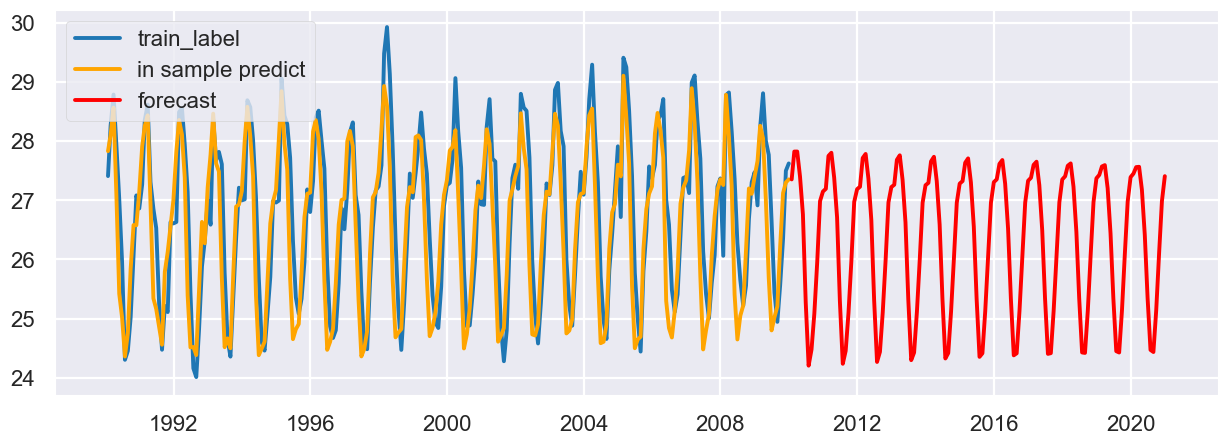

In [97]:
fcast = model.forecast(steps=132)
fc = model.get_forecast(steps=132).summary_frame()
fc_series = pd.Series(fc['mean'])

lower_series = pd.Series(fc.mean_ci_lower)
upper_series = pd.Series(fc.mean_ci_upper)

plt.rcParams.update({'figure.figsize':(15,5)})
fig, ax = plt.subplots()
ax.plot(train_data.index[-240:],train_data.average_temperature[-240:],label='train_label') # train
ax.plot(train_data.index[-240:],model.predict(start=1,end=len(train_data),dynamic=False,typ='levels')[-240:],
        color='orange',label='in sample predict') # in-sample
ax.plot(fc_series, label='forecast', color='red') # forecast
ax.legend(loc='upper left')